In [ ]:
# we need the following libraries, so let's install them
!pip install boto3
!pip install torchxrayvision
!pip install SimpleITK
!pip install radiomics
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 78.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 58.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 32.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for radiomics: filename=radiomics-0.1-py3-none-any.whl size=6107 sha256=816e3cf2c87a0faa2036ec1238f7f0ac5a348cb4c99858fc9fe533d86e67c5da
  Sto

In [ ]:
# importing libraries
import boto3
import numpy as np
import pandas as pd
from glob import glob
import os
import skimage
import torchxrayvision as xrv
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
path = os.getcwd()
name_of_folder = 'NIH-ChestXray-14'
path = path+'/sample_data' + '/' + name_of_folder
path_targets = path+'/'+'targets'
path_images = path+'/'+'images'
path_codes = path+'/'+'codes'

try:
  os.makedirs(path)
except:
  pass

try:
  os.makedirs(path_targets + '/all_findings_expert_labels')
  os.makedirs(path_targets + '/four_findings_expert_labels')
except:
  pass

try:
  os.makedirs(path_images + '/NIH-CXR-14-small')
  os.makedirs(path_images + '/NIH-CXR-14-small/images')

except:
  pass

try:
  os.makedirs(path_codes)
except:
  pass


In [ ]:
# importing written classes and methods
import sys
sys.path.insert(1, path_codes)

In [ ]:
## my AWS credentials

#Access key ID ****************
#Secret access key ****************
#User name ****************
#Password ****************

In [ ]:
# connecting to the bucket of image data in S3
aws_access_key_id = '****************'
aws_secret_access_key = '****************'
region='us-east-1'
Bucket = 'um2ii-datasets'
s3 = boto3.client(service_name = 's3',
                    region_name = region,
                    aws_access_key_id = aws_access_key_id,
                    aws_secret_access_key = aws_secret_access_key)


In [ ]:
# downloading some NIH data (labels + a single image with original size)
os.chdir(path_targets + '/four_findings_expert_labels')
s3.download_file(Bucket=Bucket,Filename='LICENSE',Key='NIH-ChestXray-14/four_findings_expert_labels/LICENSE')
s3.download_file(Bucket=Bucket,Filename='README.md',Key='NIH-ChestXray-14/four_findings_expert_labels/README.md')
s3.download_file(Bucket=Bucket,Filename='individual_readers.csv',Key='NIH-ChestXray-14/four_findings_expert_labels/individual_readers.csv')
s3.download_file(Bucket=Bucket,Filename='test_labels.csv',Key='NIH-ChestXray-14/four_findings_expert_labels/test_labels.csv')
s3.download_file(Bucket=Bucket,Filename='validation_labels.csv',Key='NIH-ChestXray-14/four_findings_expert_labels/validation_labels.csv')

In [ ]:
os.chdir(path_images + '/NIH-CXR-14-small')
s3.download_file(Bucket=Bucket,Filename='BBox_List_2017.csv',Key='NIH-ChestXray-14/NIH-CXR-14-small/BBox_List_2017.csv')
s3.download_file(Bucket=Bucket,Filename='Data_Entry_2017.md',Key='NIH-ChestXray-14/NIH-CXR-14-small/Data_Entry_2017.csv')
s3.download_file(Bucket=Bucket,Filename='metadata.csv',Key='NIH-ChestXray-14/NIH-CXR-14-small/metadata.csv')

In [ ]:
os.chdir(path_images + '/NIH-CXR-14-small')
data = pd.read_csv('metadata.csv')
data.head(2)

,Image Index,Patient ID,Patient Age,Patient Gender,View Position,No Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,58,M,PA,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,58,M,PA,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# we check the size of the data
print(data.shape)
# getting the name of the files in the csv (target) folder
all_names = list(data.iloc[:,0].values)
n_images = data.shape[0]
# making the name of base directory (folder) that data are going to be saved
base_key_path = 'NIH-ChestXray-14/NIH-CXR-14-small/images/'
os.chdir(path_images + '/NIH-CXR-14-small/images')

(112120, 20)


In [ ]:
# downloading all images one by one
for name_ in tqdm(all_names):
  my_key = base_key_path + name_
  # the extension of the filese in AWS s3 is jpg and not png. so the name of each file should be corrected
  s3.download_file(Bucket=Bucket,Filename=name_.split('.png')[0] + '.jpg',Key=my_key.split('.png')[0] + '.jpg')


100%|██████████| 112120/112120 [6:07:06<00:00,  5.09it/s]


In [ ]:
os.chdir(path_images + '/NIH-CXR-14-small')
# opening the csv target file "BBox_List_2017.csv"
data = pd.read_csv('BBox_List_2017.csv')
data.head(2)

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN


In [ ]:
# this number says the number of images that have the information on the location of the object in the image
data.shape

(984, 9)

In [ ]:
os.chdir(path_targets + '/four_findings_expert_labels')
# openning another target files
data = pd.read_csv('individual_readers.csv')
data.head(2)

,Patient ID,Image ID,Reader ID,Fracture,Pneumothorax,Airspace opacity,Nodule/mass,Set ID
0,13,00000013_008.png,4295367682,NO,YES,YES,NO,test
1,13,00000013_008.png,4295232296,NO,NO,YES,NO,test


In [ ]:
# the number of images with the above information
data.shape

(13081, 8)

In [ ]:
os.chdir(path_targets + '/four_findings_expert_labels')
data = pd.read_csv('test_labels.csv')
data.head(2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Fracture,Pneumothorax,Airspace opacity,Nodule or mass,Set Id
0,00000013_008.png,No Finding,8,13,60,M,AP,3056,2544,0.139,0.139,NO,NO,YES,NO,test
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57,M,AP,2500,2048,0.168,0.168,NO,YES,NO,NO,test


In [ ]:
data.shape

(1962, 16)

In [ ]:
os.chdir(path_targets + '/four_findings_expert_labels')
data = pd.read_csv('validation_labels.csv')
data.head(2)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Fracture,Pneumothorax,Airspace opacity,Nodule or mass,Set Id
0,00000119_001.png,Atelectasis,1,119,56,M,AP,2500,2048,0.168,0.168,NO,NO,NO,NO,val
1,00000134_000.png,Infiltration,0,134,76,F,AP,2048,2500,0.168,0.168,NO,NO,YES,NO,val


In [ ]:
data.shape

(2414, 16)

In [ ]:
# ======================================================================================================================================
#========================================= The following code wont run and a comprehensive version is prepared in another notebook
#=======================================================================================================================================

In [ ]:
names_of_images, number_of_images

(['/content/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg'], 1)

In [ ]:
# converting segmented images to filters(pixels with either 0 or 1 values)
filters, image = ChestXRaySegmentation(threshold=0.5, image_size=512).get_filter_image(names_of_images[0])


In [ ]:
# getting the size of segments
my_segments.shape

torch.Size([1, 14, 512, 512])

In [ ]:
# the name of all segments
segment_names = ['Left Clavicle',
                  'Right Clavicle',
                  'Left Scapula',
                  'Right Scapula',
                  'Left Lung',
                  'Right Lung',
                  'Left Hilus Pulmonis',
                  'Right Hilus Pulmonis',
                  'Heart',
                  'Aorta',
                  'Facies Diaphragmatica',
                  'Mediastinum',
                  'Weasand',
                  'Spine']

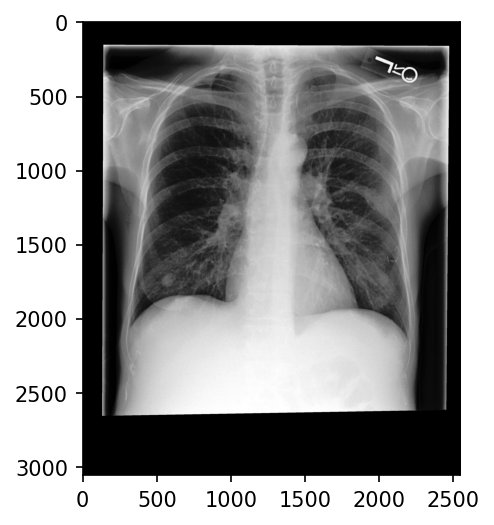

In [ ]:
#ploting the image with the original size
plt.figure(dpi=150)
plt.imshow(skimage.io.imread(names_of_images[0]),cmap='gray')

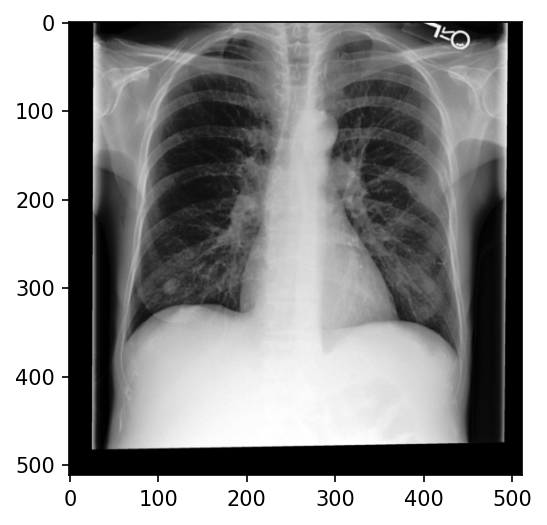

In [ ]:
#ploting the processed image
plt.figure(dpi=150)
plt.imshow(image[0,:,:],cmap='gray')

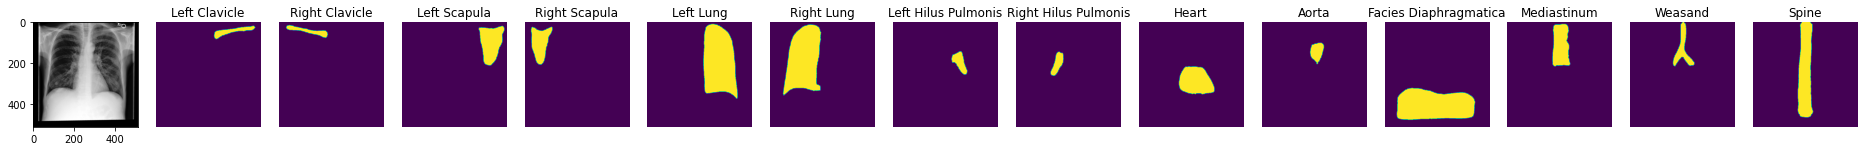

In [ ]:
# plotting all filters + processed image
plt.figure(figsize=(26, 5)) # the size of figures
plt.subplot(1, 14 + 1, 1) # 1+ 14 subplots
plt.imshow(image[0,:,:], cmap='gray')
for i in range(len(segment_names)):
    plt.subplot(1, len(segment_names) + 1, i + 2)
    plt.imshow(filters[0, i,:,:])
    plt.title(segment_names[i])
    plt.axis('off')
plt.tight_layout()

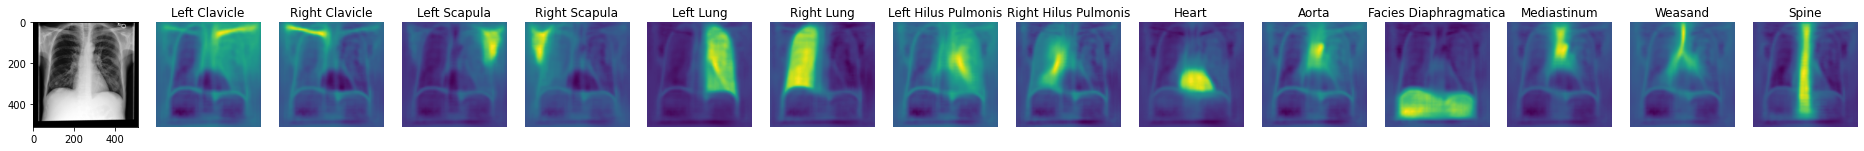

In [ ]:
# plotting all segments
plt.figure(figsize=(26, 5))
plt.subplot(1, 14 + 1, 1)
plt.imshow(image[0,:,:], cmap='gray')
for i in range(len(segment_names)):
    plt.subplot(1, len(segment_names) + 1, i + 2)
    plt.imshow(my_segments[0, i,:,:])
    plt.title(segment_names[i])
    plt.axis('off')
plt.tight_layout()